# Testing Notebook

## Imports

In [1]:
# %load ~/dev/marthaler/header.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from dataclasses import dataclass
from typing import Dict, Any, Tuple
from datetime import datetime, timedelta

import warnings

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rc('figure', figsize=(16, 10))
plt.rc('font', size=14)


In [14]:
from jax_image_prediction import SimVP_Model, SimVP_Model_No_Hid, shift_image, Encoder

In [3]:
import math

import equinox as eqx
import jax
from jax import vmap
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import optax  # https://github.com/deepmind/optax
import torch

In [4]:
from jaxtyping import Array, Float, Int, PyTree

In [5]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


## Functions

## Load Data

In [6]:
imgs = np.load('/Users/daniel.marthaler/dev/SimVP/data/moving_mnist/mnist_test_seq.npy')
from dataloader_moving_mnist import load_data

## Parameters

In [7]:
# model parameters
in_shape=[10, 1, 64, 64]
spatio_kernel_enc = 3
spatio_kernel_dec = 3
model_type = 'gSTA'
hid_S = 64
hid_T = 512
N_T = 8
N_S = 4

# training
BATCH_SIZE = 64
LEARNING_RATE = 3e-4
TOTAL_STEPS = 1500
TOTAL_EPOCH = 5
PRINT_EVERY = 30
SEED = 42
val_batch_size=16
num_workers=8
drop_path = 0
sched = 'onecycle'

In [8]:
key = jax.random.PRNGKey(SEED)

In [9]:
train_loader, vali_loader, test_loader, data_mean, data_std = load_data(
    BATCH_SIZE,
    BATCH_SIZE,
    '/Users/daniel.marthaler/dev/SimVP/data',
    num_workers
)
x_batch, y_batch = next(iter(train_loader))
x_batch = x_batch.numpy()
y_batch = y_batch.numpy()

## Model

In [10]:
model = SimVP_Model(
    key,
    tuple(in_shape),
    hid_S,
    hid_T,
    N_S,
    N_T,
    spatio_kernel_enc=spatio_kernel_enc,
    spatio_kernel_dec=spatio_kernel_dec
)

In [15]:
T, C, H, W = tuple(in_shape)
H, W = int(H / 2 ** (N_S / 2)), int(W / 2 ** (N_S / 2))  # downsample 1 / 2**(N_S/2)
enc = Encoder(
    key,
    C,
    hid_S,
    N_S,
    spatio_kernel_enc,
)

In [19]:
B, T, C, H, W = x_batch.shape
x = x_batch.reshape(B * T, C, H, W)
embed, skip = vmap(enc)(x)

In [20]:
embed.shape

(640, 64, 16, 16)

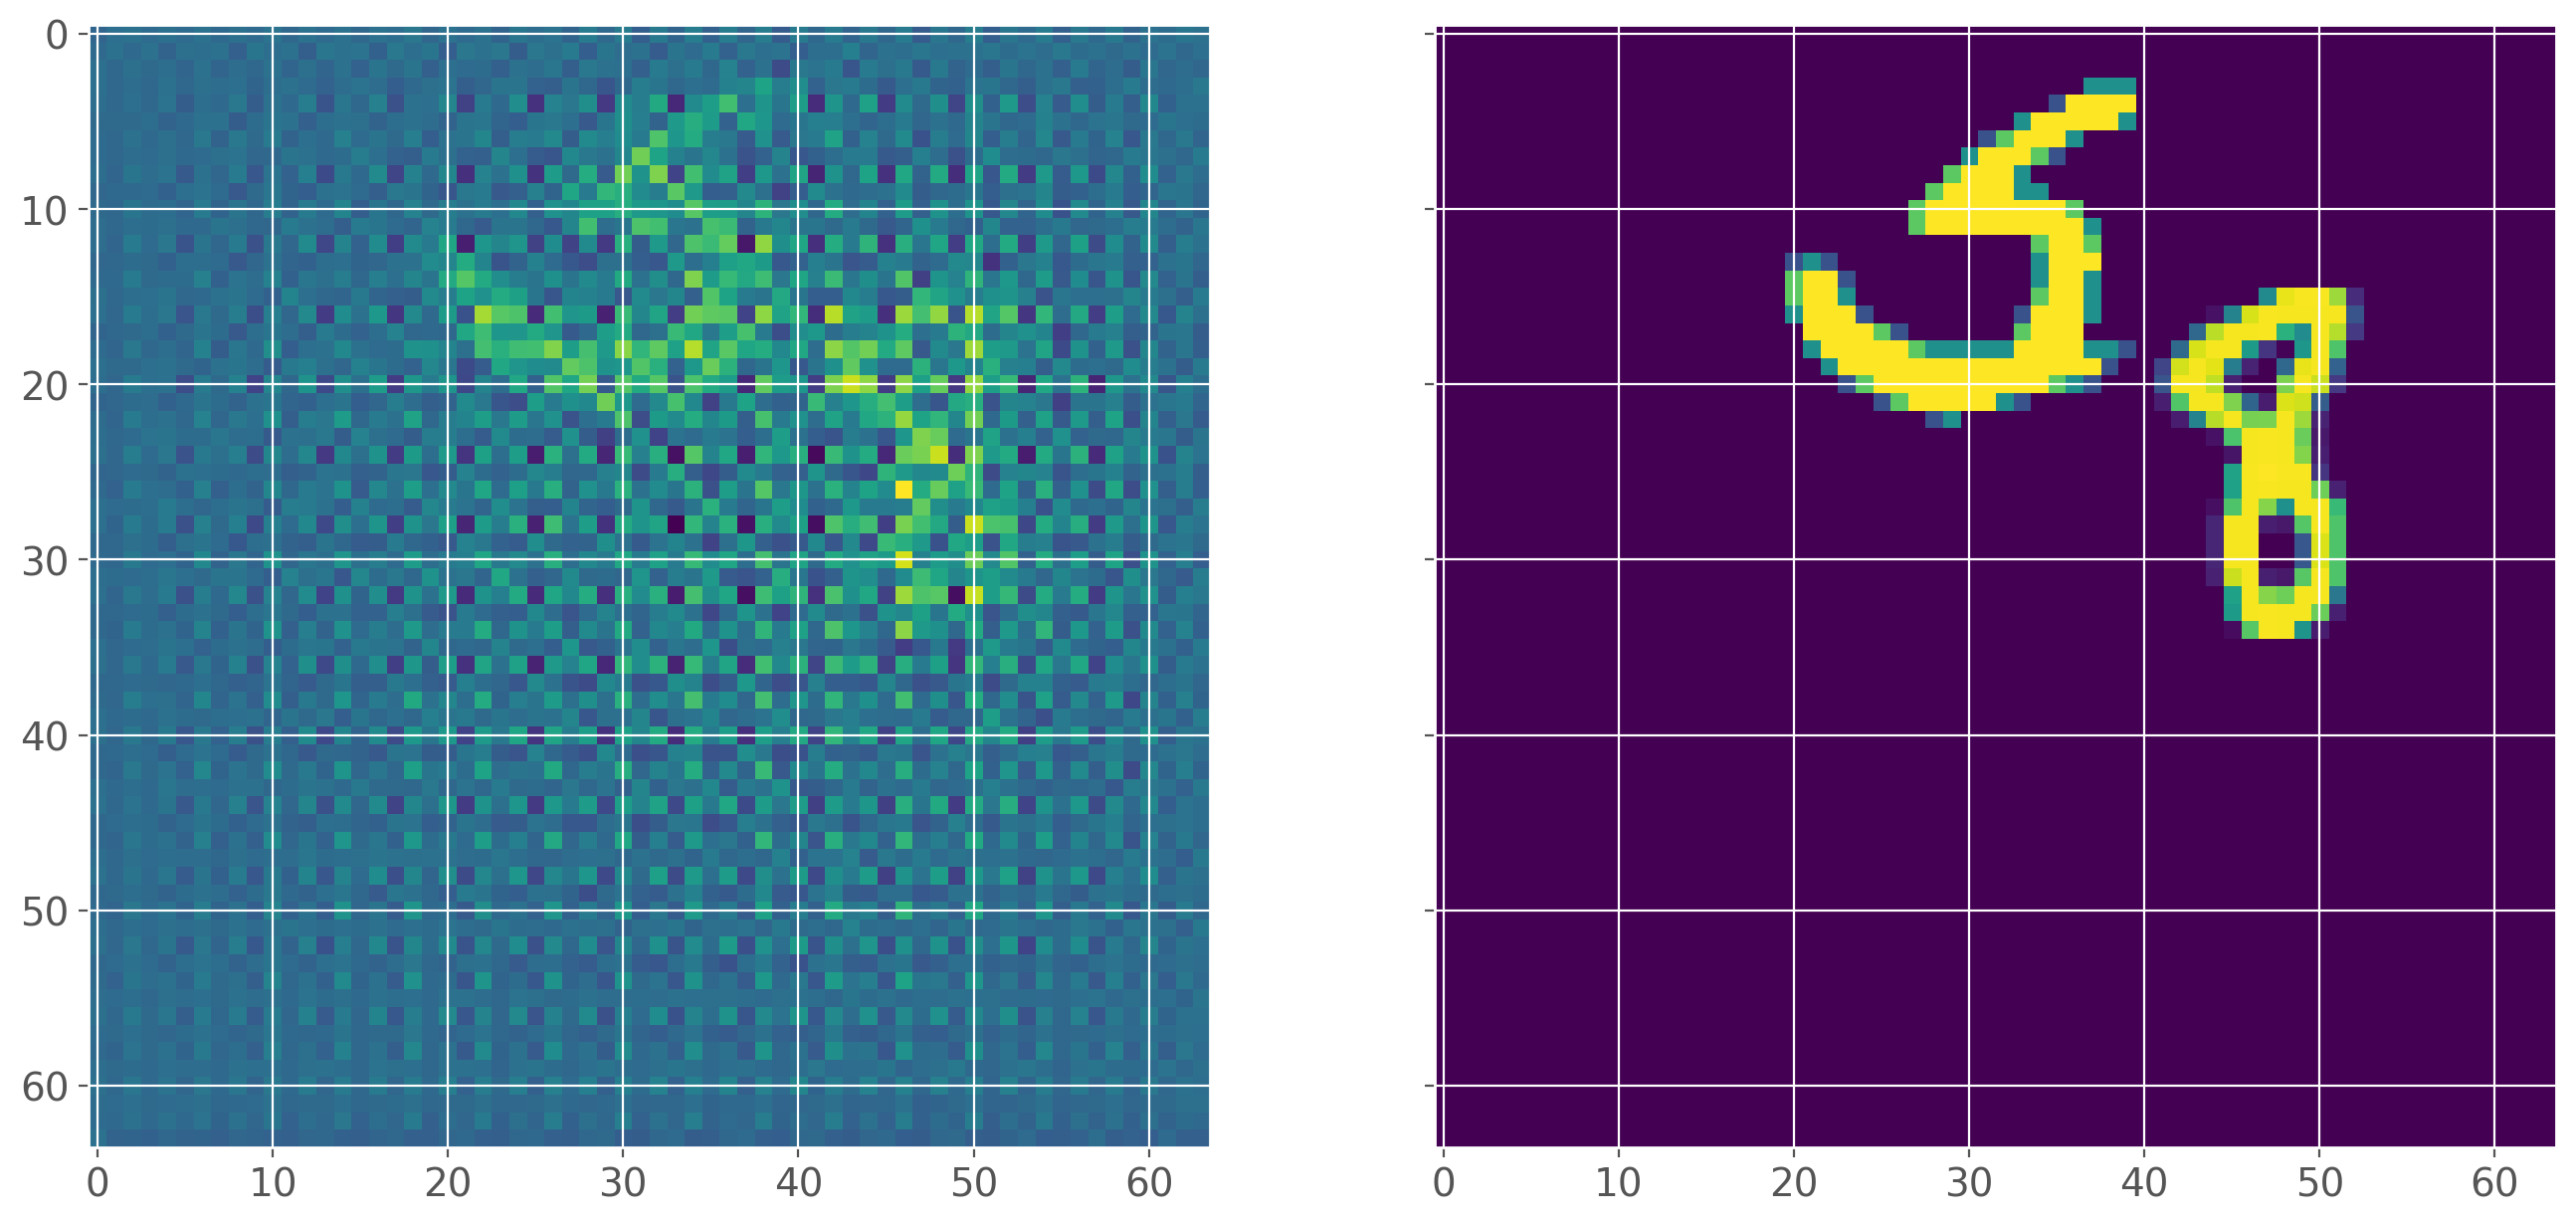

In [11]:
y_pred = model(x_batch)
j=2; k=5; l=0
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.imshow(y_pred[j,k,l,:,:])
ax2.imshow(x_batch[j,k,l,:,:])
plt.show()

## Training

In [33]:
def compute_loss(model, x, y):
    pred_y = model(x)
    # Trains with respect to huber loss
    #return optax.losses.huber_loss(pred_y, y).sum()
    return optax.losses.l2_loss(pred_y, y).sum()

loss = eqx.filter_jit(compute_loss)

In [34]:
def evaluate(model, testloader: torch.utils.data.DataLoader):
    """This function evaluates the model on the test dataset,
    computing both the average loss and the average accuracy.
    """
    avg_loss = 0
    for x, y in testloader:
        x = x.numpy().astype(float)
        #y = y.numpy().astype(float)
        # Note that all the JAX operations happen inside `loss` ,
        # and both have JIT wrappers, so this is fast.
        avg_loss += loss(model, x, x)
    return avg_loss / len(testloader)

In [35]:
cosine_decay_scheduler = optax.cosine_decay_schedule(LEARNING_RATE, decay_steps=TOTAL_STEPS, alpha=0.95)

In [36]:
optim = optax.adamw(learning_rate=cosine_decay_scheduler)

In [37]:
def train(
    model,
    trainloader: torch.utils.data.DataLoader,
    testloader: torch.utils.data.DataLoader,
    optim: optax.GradientTransformation,
    steps: int,
    print_every: int,
    first_call: bool=True,
    opt_state_saved: PyTree=None,
):
    # Just like earlier: It only makes sense to train the arrays in our model,
    # so filter out everything else.
    if first_call:
        opt_state = optim.init(eqx.filter(model, eqx.is_array))
    else:
        opt_state = opt_state_saved

    # Always wrap everything -- computing gradients, running the optimiser, updating
    # the model -- into a single JIT region. This ensures things run as fast as
    # possible.
    @eqx.filter_jit
    def make_step(
        model,
        opt_state: PyTree,
        x: Float[Array, "batch 10 1 64 64"],
        y: Float[Array, "batch 10 1 64 64"],
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    # Loop over our training dataset as many times as we need.
    def infinite_trainloader():
        while True:
            yield from trainloader

    for step, (x, y) in zip(range(steps), infinite_trainloader()):
        # PyTorch dataloaders give PyTorch tensors by default,
        # so convert them to NumPy arrays.
        x = x.numpy().astype(float)
        y = y.numpy().astype(float)
        model, opt_state, train_loss = make_step(model, opt_state, x, y)
        if (step % print_every) == 0 or (step == steps - 1):
            test_loss = evaluate(model, testloader)
            print(
                f"{step}, train_loss={train_loss.item()}, test_loss={test_loss.item()}"
            )
    return model, opt_state

In [ ]:
model, opt_state_saved = train(
    new_model,
    train_loader,
    test_loader,
    optim,
    TOTAL_STEPS,
    PRINT_EVERY,
    first_call=True,
    opt_state_saved=None,
)
y_pred = model(x_batch)

# models = [model]
# states = [opt_state_saved]
# for epoch in TOTAL_EPOCH:
#     print(epoch)
#     model, opt_state_saved = train(
#         model,
#         train_loader,
#         test_loader,
#         optim,
#         TOTAL_STEPS,
#         PRINT_EVERY,
#         first_call=False,
#         opt_state_saved=opt_state_saved,
#     )
#     y_pred = model(x_batch)
#     models.append(model)
#     states.append(opt_state_saved)
#     j=2; k=5; l=0
#     fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
#     ax1.imshow(y_pred[j,k,l,:,:])
#     ax2.imshow(y_batch[j,k,l,:,:])
#     plt.show()

0, train_loss=38528.59765625, test_loss=63241.3046875
30, train_loss=12906.9013671875, test_loss=85487.3203125


In [ ]:
y_pred = model(x_batch)
j=2; k=6; l=0
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.imshow(y_pred[j,k,l,:,:])
ax2.imshow(x_batch[j,k,l,:,:])
plt.show()

## Try to load precomputed weights

In [15]:
torch_model = torch.load('mmnist_simvp_s_incepu_one_ep200.pth')
type(torch_model['enc.enc.0.conv.conv.weight'])#.shape

torch.Tensor

In [16]:
for k in torch_model.keys():
    print(k)

enc.enc.0.conv.conv.weight
enc.enc.0.conv.conv.bias
enc.enc.0.conv.norm.weight
enc.enc.0.conv.norm.bias
enc.enc.1.conv.conv.weight
enc.enc.1.conv.conv.bias
enc.enc.1.conv.norm.weight
enc.enc.1.conv.norm.bias
enc.enc.2.conv.conv.weight
enc.enc.2.conv.conv.bias
enc.enc.2.conv.norm.weight
enc.enc.2.conv.norm.bias
enc.enc.3.conv.conv.weight
enc.enc.3.conv.conv.bias
enc.enc.3.conv.norm.weight
enc.enc.3.conv.norm.bias
dec.dec.0.conv.conv.0.weight
dec.dec.0.conv.conv.0.bias
dec.dec.0.conv.norm.weight
dec.dec.0.conv.norm.bias
dec.dec.1.conv.conv.weight
dec.dec.1.conv.conv.bias
dec.dec.1.conv.norm.weight
dec.dec.1.conv.norm.bias
dec.dec.2.conv.conv.0.weight
dec.dec.2.conv.conv.0.bias
dec.dec.2.conv.norm.weight
dec.dec.2.conv.norm.bias
dec.dec.3.conv.conv.weight
dec.dec.3.conv.conv.bias
dec.dec.3.conv.norm.weight
dec.dec.3.conv.norm.bias
dec.readout.weight
dec.readout.bias
hid.enc.0.conv1.weight
hid.enc.0.conv1.bias
hid.enc.0.layers.0.conv.weight
hid.enc.0.layers.0.conv.bias
hid.enc.0.layers.0.n

## Try to overwrite model weights with these torch weights

In [17]:
from copy import deepcopy

In [18]:
new_model = deepcopy(model)

In [23]:
kk = []

In [24]:
# Copy weights over to the Encoder
for i in range(N_S):
    new_layer = eqx.tree_at(
        lambda l: (l.weight,l.bias), 
        new_model.enc.enc.layers[i].conv.conv, 
        (
            jnp.array(torch_model[f'enc.enc.{i}.conv.conv.weight'],dtype=float),
            jnp.array(torch_model[f'enc.enc.{i}.conv.conv.bias'],dtype=float)[:,jnp.newaxis,jnp.newaxis]
        )
    )
    kk.append(f'enc.enc.{i}.conv.conv.weight')
    kk.append(f'enc.enc.{i}.conv.conv.bias')
    where = lambda m: m.enc.enc.layers[i].conv.conv
    new_model = eqx.tree_at(where, new_model, new_layer)
    
    new_layer = eqx.tree_at(
        lambda l: (l.weight,l.bias), 
        new_model.enc.enc.layers[i].conv.norm, 
        (
            jnp.array(torch_model[f'enc.enc.{i}.conv.norm.weight'],dtype=float),
            jnp.array(torch_model[f'enc.enc.{i}.conv.norm.bias'],dtype=float)
        )
    )
    kk.append(f'enc.enc.{i}.conv.norm.weight')
    kk.append(f'enc.enc.{i}.conv.norm.bias')
    where = lambda m: m.enc.enc.layers[i].conv.norm
    new_model = eqx.tree_at(where, new_model, new_layer)

In [25]:
# Copy over the hidden weights 
# Encoder
for i in range(N_T):
    new_layer = eqx.tree_at(
        lambda l: (l.weight,l.bias), 
        new_model.hid.enc.layers[i].conv1, 
        (
            jnp.array(torch_model[f'hid.enc.{i}.conv1.weight'],dtype=float),
            jnp.array(torch_model[f'hid.enc.{i}.conv1.bias'],dtype=float)[:,jnp.newaxis,jnp.newaxis]
        )
    )
    kk.append(f'hid.enc.{i}.conv1.weight')
    kk.append(f'hid.enc.{i}.conv1.bias')
    where = lambda m: m.hid.enc.layers[i].conv1
    new_model = eqx.tree_at(where, new_model, new_layer)
    
    for j in range(4):
        new_layer = eqx.tree_at(
            lambda l: (l.weight,l.bias), 
            new_model.hid.enc.layers[i].layers[j].conv,
            (
                jnp.array(torch_model[f'hid.enc.{i}.layers.{j}.conv.weight'],dtype=float),
                jnp.array(torch_model[f'hid.enc.{i}.layers.{j}.conv.bias'],dtype=float)[:,jnp.newaxis,jnp.newaxis]
            )
        )
        kk.append(f'hid.enc.{i}.layers.{j}.conv.weight')
        kk.append(f'hid.enc.{i}.layers.{j}.conv.bias')
        where = lambda m: m.hid.enc.layers[i].layers[j].conv
        new_model = eqx.tree_at(where, new_model, new_layer)
        
        new_layer = eqx.tree_at(
            lambda l: (l.weight,l.bias), 
            new_model.hid.enc.layers[i].layers[j].norm,
            (
                jnp.array(torch_model[f'hid.enc.{i}.layers.{j}.norm.weight'],dtype=float),
                jnp.array(torch_model[f'hid.enc.{i}.layers.{j}.norm.bias'],dtype=float)
            )
        )
        kk.append(f'hid.enc.{i}.layers.{j}.norm.weight')
        kk.append(f'hid.enc.{i}.layers.{j}.norm.bias')
        where = lambda m: m.hid.enc.layers[i].layers[j].norm
        new_model = eqx.tree_at(where, new_model, new_layer)
# Decoder
for i in range(N_T):
    new_layer = eqx.tree_at(
        lambda l: (l.weight,l.bias), 
        new_model.hid.dec.layers[i].conv1, 
        (
            jnp.array(torch_model[f'hid.dec.{i}.conv1.weight'],dtype=float),
            jnp.array(torch_model[f'hid.dec.{i}.conv1.bias'],dtype=float)[:,jnp.newaxis,jnp.newaxis]
        )
    )
    kk.append(f'hid.dec.{i}.conv1.weight')
    kk.append(f'hid.dec.{i}.conv1.bias')    
    where = lambda m: m.hid.dec.layers[i].conv1
    new_model = eqx.tree_at(where, new_model, new_layer)
    
    for j in range(4):
        new_layer = eqx.tree_at(
            lambda l: (l.weight,l.bias), 
            new_model.hid.dec.layers[i].layers[j].conv,
            (
                jnp.array(torch_model[f'hid.dec.{i}.layers.{j}.conv.weight'],dtype=float),
                jnp.array(torch_model[f'hid.dec.{i}.layers.{j}.conv.bias'],dtype=float)[:,jnp.newaxis,jnp.newaxis]
            )
        )
        kk.append(f'hid.dec.{i}.layers.{j}.conv.weight')
        kk.append(f'hid.dec.{i}.layers.{j}.conv.bias')   
        where = lambda m: m.hid.dec.layers[i].layers[j].conv
        new_model = eqx.tree_at(where, new_model, new_layer)
        
        new_layer = eqx.tree_at(
            lambda l: (l.weight,l.bias), 
            new_model.hid.dec.layers[i].layers[j].norm,
            (
                jnp.array(torch_model[f'hid.dec.{i}.layers.{j}.norm.weight'],dtype=float),
                jnp.array(torch_model[f'hid.dec.{i}.layers.{j}.norm.bias'],dtype=float)
            )
        )
        kk.append(f'hid.dec.{i}.layers.{j}.norm.weight')
        kk.append(f'hid.dec.{i}.layers.{j}.norm.bias') 
        where = lambda m: m.hid.dec.layers[i].layers[j].norm
        new_model = eqx.tree_at(where, new_model, new_layer)

In [26]:
# Copy over the Decoder weights
for i in range(N_S):
    if i%2==0:
        new_layer = eqx.tree_at(
            lambda l: (l.weight,l.bias), 
            new_model.dec.dec.layers[i].conv.conv[0], 
            (
                jnp.array(torch_model[f'dec.dec.{i}.conv.conv.0.weight'],dtype=float),
                jnp.array(torch_model[f'dec.dec.{i}.conv.conv.0.bias'],dtype=float)[:,jnp.newaxis,jnp.newaxis]
            )
        )
        kk.append(f'dec.dec.{i}.conv.conv.0.weight')
        kk.append(f'dec.dec.{i}.conv.conv.0.bias') 
        where = lambda m: m.dec.dec.layers[i].conv.conv[0]
    else:
        new_layer = eqx.tree_at(
            lambda l: (l.weight,l.bias), 
            new_model.dec.dec.layers[i].conv.conv, 
            (
                jnp.array(torch_model[f'dec.dec.{i}.conv.conv.weight'],dtype=float),
                jnp.array(torch_model[f'dec.dec.{i}.conv.conv.bias'],dtype=float)[:,jnp.newaxis,jnp.newaxis]
            )
        )
        kk.append(f'dec.dec.{i}.conv.conv.weight')
        kk.append(f'dec.dec.{i}.conv.conv.bias') 
        where = lambda m: m.dec.dec.layers[i].conv.conv        
    
    new_model = eqx.tree_at(where, new_model, new_layer)
    
    new_layer = eqx.tree_at(
        lambda l: (l.weight,l.bias), 
        new_model.dec.dec.layers[i].conv.norm, 
        (
            jnp.array(torch_model[f'dec.dec.{i}.conv.norm.weight'],dtype=float),
            jnp.array(torch_model[f'dec.dec.{i}.conv.norm.bias'],dtype=float)
        )
    )
    kk.append(f'dec.dec.{i}.conv.norm.weight')
    kk.append(f'dec.dec.{i}.conv.norm.bias') 
    where = lambda m: m.dec.dec.layers[i].conv.norm
    new_model = eqx.tree_at(where, new_model, new_layer)

In [27]:
new_layer = eqx.tree_at(
    lambda l: (l.weight,l.bias), 
    new_model.dec.readout, 
    (
        jnp.array(torch_model[f'dec.readout.weight'],dtype=float),
        jnp.array(torch_model[f'dec.readout.bias'],dtype=float)
    )
)
kk.append(f'dec.readout.weight')
kk.append(f'dec.readout.bias') 
where = lambda m: m.dec.readout
new_model = eqx.tree_at(where, new_model, new_layer)

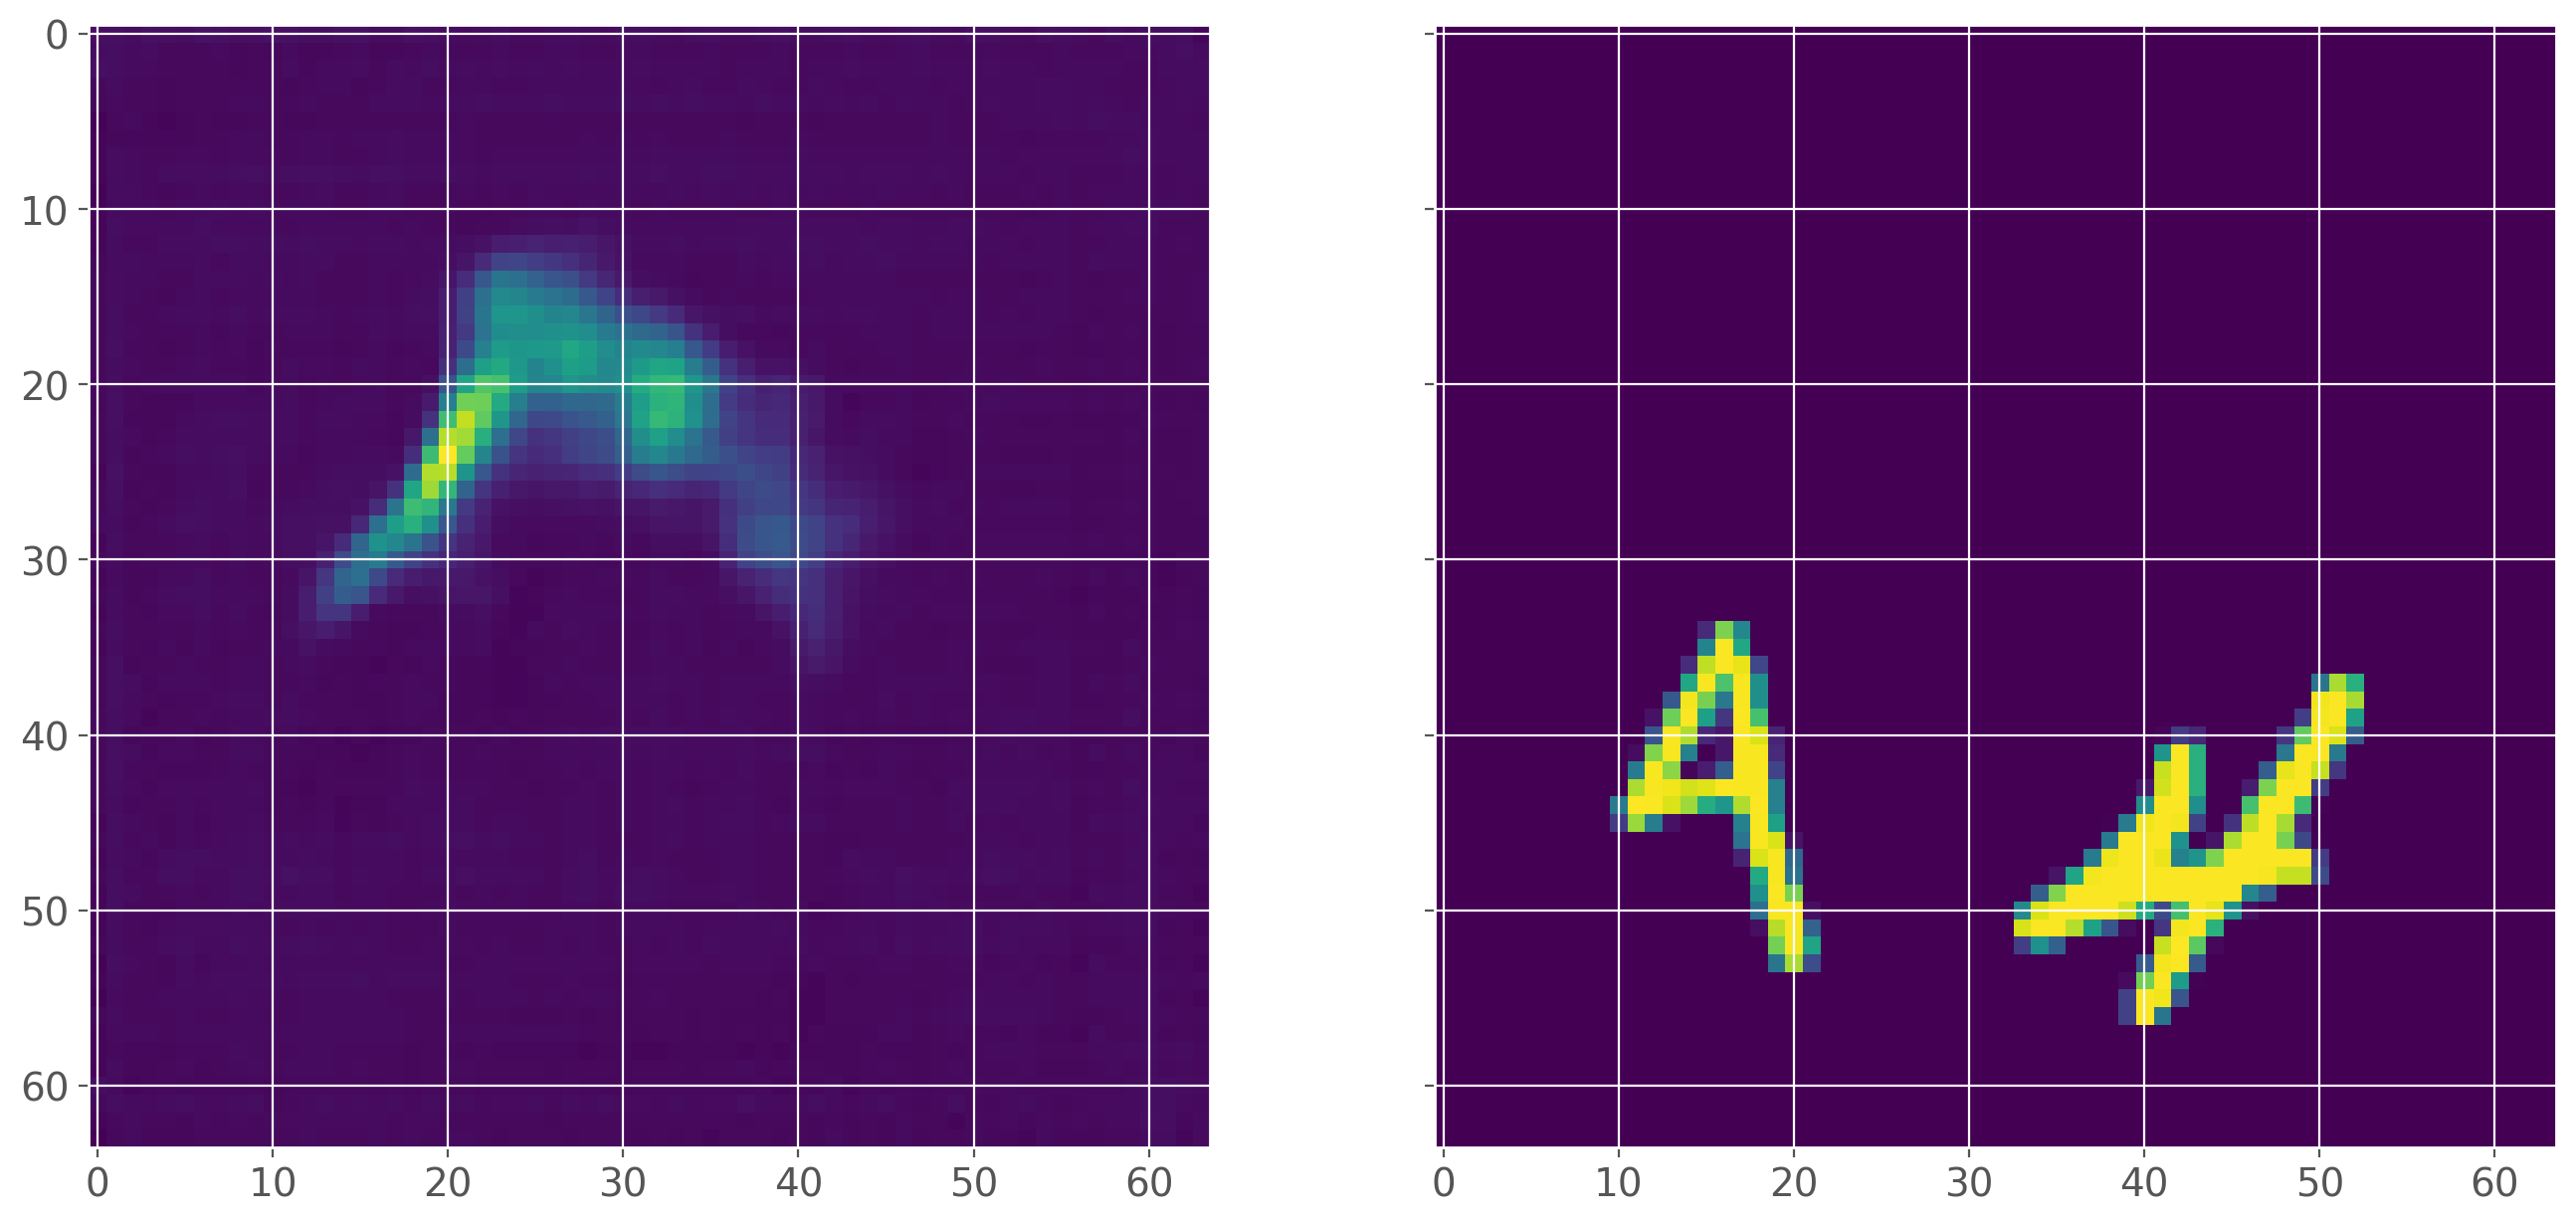

In [82]:
y_pred = new_model(x_batch)
j=2; k=6; l=0
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.imshow(y_pred[j,k,l,:,:])
ax2.imshow(x_batch[j,k,l,:,:])
plt.show()

In [28]:
len(torch_model.keys()), len(kk)

(322, 322)

In [29]:
torch_model.keys()==kk

False

In [32]:
for k1,k2 in zip(sorted(torch_model.keys()),sorted(kk)):
    if(k1==k2):
        continue
    else:
        print(k1,k2)